# CNN + MaxPool
Mess with class weights.
Increased from 6:1 to 12:1.
Saw more predicted 0.
But accuracy and MCC went down.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-20 22:37:17.678378


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=128 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_LINES = 15   # 15 to analyze all of them
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN \
                    and gene_id in self.gene2rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    cnn.add(cnn3_layer)
    cnn.add(cnn4_layer)
    cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-20 22:37:50.310571
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 128)         4224      
                                                                 
 conv1d_1 (Conv1D)           (None, 4983, 128)         131200    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1244, 128)        0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 1237, 64)          65600     
                                                                 
 conv1d_3 (Conv1D)           (None, 1230, 64)          32832     
                             

## Training

In [19]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        cwd = {0: 12., 1: 1.}
        print('Adjusted class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [20]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-20 23:24:02.115399
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4236 sequences.
2023-03-20 23:24:10.165696

Training # 1 1
2023-03-20 23:24:10.166369
2023-03-20 23:24:10.166417
Discriminator ZERO -1
Computed class weights: {0: 3.6573275862068964, 1: 0.5791808873720137}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:24:11.376044


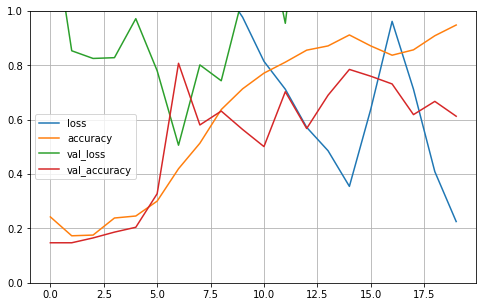


2023-03-20 23:26:34.801710

Testing # 1 1
2023-03-20 23:26:34.803119
2023-03-20 23:26:34.803455
PREDICT
2023-03-20 23:26:35.027589
Test 1:0 718:124 85.27%
Predict 1:0 556:286 66.03%
Test sizes (842, 4997) (842,)
Range of scores: 1.4234862e-27 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 42  82]
 [244 474]]
Normalized matrix
 [[0.04988124 0.09738717]
 [0.28978622 0.56294537]]


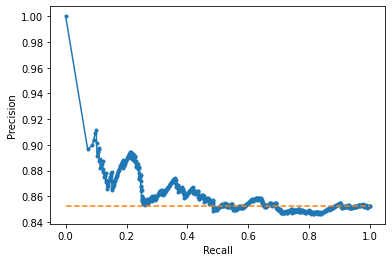

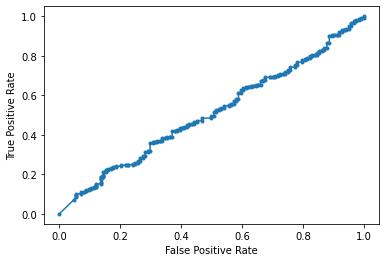

Accuracy: 61.28% Precision: 85.25% Recall: 66.02%
F1: 74.41% MCC: -0.0008
AUPRC: 86.69% AUROC: 50.96%
 accuracy [61.282660332541575]
 precision [85.25179856115108]
 recall [66.01671309192201]
 F1 [74.41130298273157]
 MCC [-0.0008404396300969461]
 AUPRC [86.69157628753592]
 AUROC [50.96482163716417]
2023-03-20 23:26:36.191118

Training # 1 2
2023-03-20 23:26:36.191671
2023-03-20 23:26:36.191721
Discriminator ZERO -1
Computed class weights: {0: 3.493801652892562, 1: 0.5835058661145618}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:26:37.388743


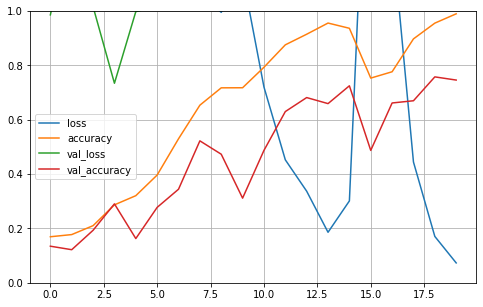


2023-03-20 23:28:39.947875

Testing # 1 2
2023-03-20 23:28:39.947974
2023-03-20 23:28:39.948010
PREDICT
2023-03-20 23:28:40.168786
Test 1:0 750:104 87.82%
Predict 1:0 713:141 83.49%
Test sizes (854, 4997) (854,)
Range of scores: 1.4253719e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 14  90]
 [127 623]]
Normalized matrix
 [[0.01639344 0.10538642]
 [0.14871194 0.7295082 ]]


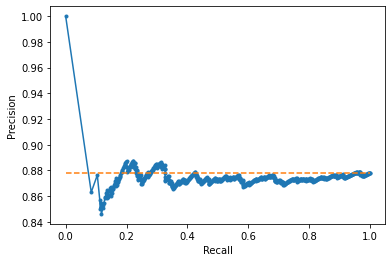

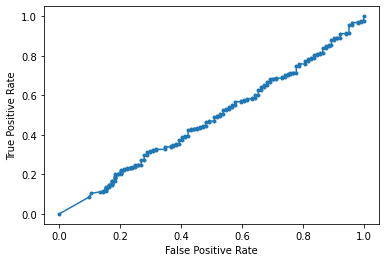

Accuracy: 74.59% Precision: 87.38% Recall: 83.07%
F1: 85.17% MCC: -0.0306
AUPRC: 87.85% AUROC: 48.00%
 accuracy [74.59016393442623]
 precision [87.37727910238429]
 recall [83.06666666666666]
 F1 [85.16746411483254]
 MCC [-0.03058067289832514]
 AUPRC [87.84771642109934]
 AUROC [47.996153846153845]
2023-03-20 23:28:41.541068

Training # 1 3
2023-03-20 23:28:41.541188
2023-03-20 23:28:41.541224
Discriminator ZERO -1
Computed class weights: {0: 3.6792656587473003, 1: 0.5786345108695652}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:28:43.701800


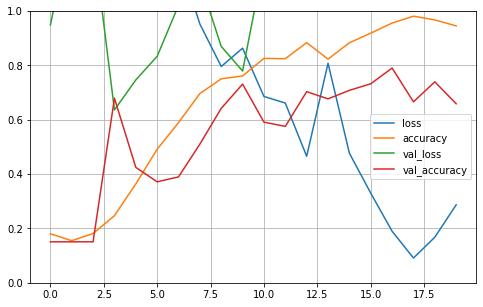


2023-03-20 23:30:45.889179

Testing # 1 3
2023-03-20 23:30:45.889279
2023-03-20 23:30:45.889325
PREDICT
2023-03-20 23:30:46.108030
Test 1:0 704:125 84.92%
Predict 1:0 607:222 73.22%
Test sizes (829, 4997) (829,)
Range of scores: 2.3968372e-10 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 32  93]
 [190 514]]
Normalized matrix
 [[0.03860072 0.11218335]
 [0.2291918  0.62002413]]


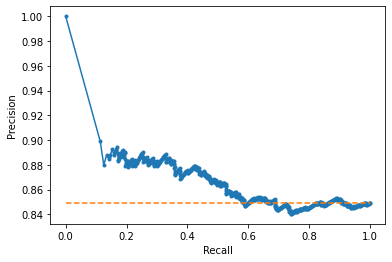

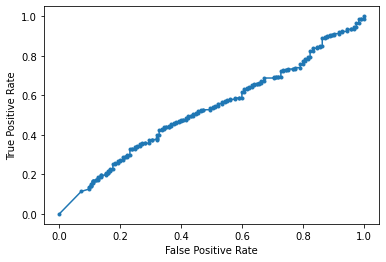

Accuracy: 65.86% Precision: 84.68% Recall: 73.01%
F1: 78.41% MCC: -0.0112
AUPRC: 87.29% AUROC: 52.82%
 accuracy [65.86248492159228]
 precision [84.67874794069192]
 recall [73.01136363636364]
 F1 [78.4134248665141]
 MCC [-0.011221709894725016]
 AUPRC [87.29180980683759]
 AUROC [52.81931818181819]
2023-03-20 23:30:47.263516

Training # 1 4
2023-03-20 23:30:47.263645
2023-03-20 23:30:47.263701
Discriminator ZERO -1
Computed class weights: {0: 3.6515151515151514, 1: 0.5793269230769231}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:30:48.469500


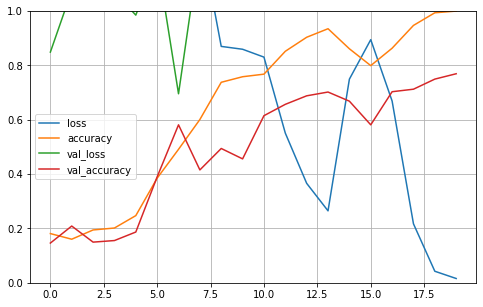


2023-03-20 23:33:15.061891

Testing # 1 4
2023-03-20 23:33:15.061979
2023-03-20 23:33:15.062015
PREDICT
2023-03-20 23:33:15.340291
Test 1:0 736:126 85.38%
Predict 1:0 767:95 88.98%
Test sizes (862, 4997) (862,)
Range of scores: 1.2468103e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 11 115]
 [ 84 652]]
Normalized matrix
 [[0.01276102 0.13341067]
 [0.0974478  0.75638051]]


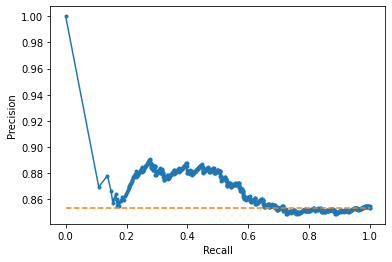

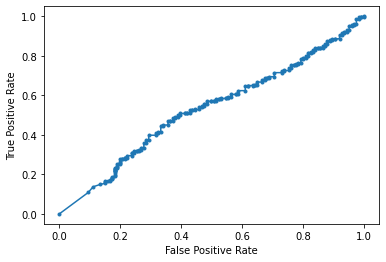

Accuracy: 76.91% Precision: 85.01% Recall: 88.59%
F1: 86.76% MCC: -0.0303
AUPRC: 87.34% AUROC: 52.96%
 accuracy [76.91415313225059]
 precision [85.00651890482399]
 recall [88.58695652173914]
 F1 [86.7598137059215]
 MCC [-0.030266814264787157]
 AUPRC [87.34322604891551]
 AUROC [52.96378968253968]
2023-03-20 23:33:16.765643

Training # 1 5
2023-03-20 23:33:16.766333
2023-03-20 23:33:16.766383
Discriminator ZERO -1
Computed class weights: {0: 3.535490605427975, 1: 0.5823590096286108}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:33:19.450018


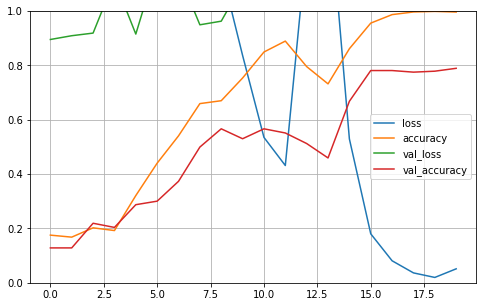


2023-03-20 23:35:24.145641

Testing # 1 5
2023-03-20 23:35:24.146064
2023-03-20 23:35:24.146102
PREDICT
2023-03-20 23:35:24.381528
Test 1:0 740:109 87.16%
Predict 1:0 763:86 89.87%
Test sizes (849, 4997) (849,)
Range of scores: 3.5074092e-05 to 1.0
Score threshold 0.5
Confusion matrix
 [[  8 101]
 [ 78 662]]
Normalized matrix
 [[0.00942285 0.11896349]
 [0.09187279 0.77974087]]


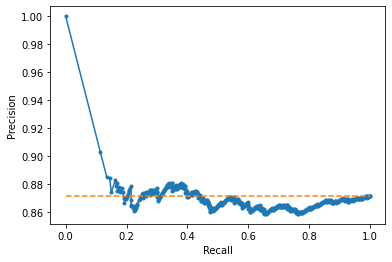

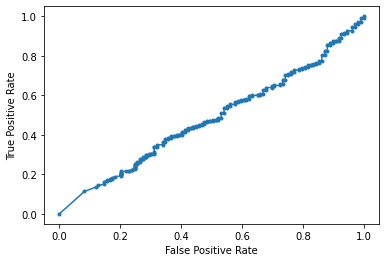

Accuracy: 78.92% Precision: 86.76% Recall: 89.46%
F1: 88.09% MCC: -0.0355
AUPRC: 87.85% AUROC: 48.24%
 accuracy [78.91637220259128]
 precision [86.76277850589777]
 recall [89.45945945945945]
 F1 [88.09048569527612]
 MCC [-0.03549078738091866]
 AUPRC [87.85297460452107]
 AUROC [48.24386312918423]
2023-03-20 23:35:25.366563

Training # 2 1
2023-03-20 23:35:25.366660
2023-03-20 23:35:25.366691
Discriminator ZERO -1
Computed class weights: {0: 3.625536480686695, 1: 0.5799862684517679}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:35:26.549497


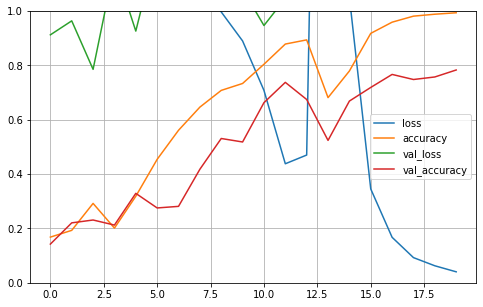


2023-03-20 23:37:27.697326

Testing # 2 1
2023-03-20 23:37:27.697434
2023-03-20 23:37:27.697475
PREDICT
2023-03-20 23:37:27.943117
Test 1:0 735:122 85.76%
Predict 1:0 759:98 88.56%
Test sizes (857, 4997) (857,)
Range of scores: 1.7609462e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 17 105]
 [ 81 654]]
Normalized matrix
 [[0.01983664 0.12252042]
 [0.09451575 0.76312719]]


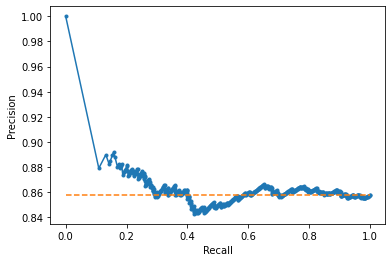

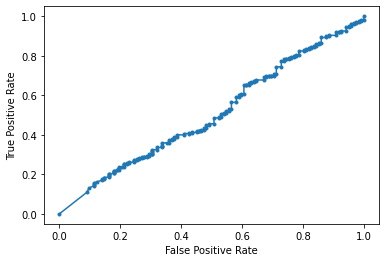

Accuracy: 78.30% Precision: 86.17% Recall: 88.98%
F1: 87.55% MCC: 0.0320
AUPRC: 87.02% AUROC: 50.78%
 accuracy [78.29638273045506]
 precision [86.16600790513834]
 recall [88.9795918367347]
 F1 [87.55020080321286]
 MCC [0.031994984127450124]
 AUPRC [87.01999990659907]
 AUROC [50.781755325080844]
2023-03-20 23:37:29.114755

Training # 2 2
2023-03-20 23:37:29.114903
2023-03-20 23:37:29.114949
Discriminator ZERO -1
Computed class weights: {0: 3.6497844827586206, 1: 0.5793705097502566}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:37:30.484013


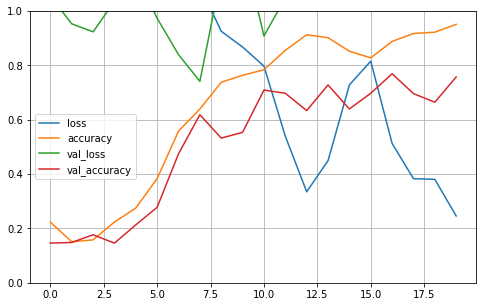


2023-03-20 23:39:33.509419

Testing # 2 2
2023-03-20 23:39:33.509541
2023-03-20 23:39:33.509580
PREDICT
2023-03-20 23:39:33.722398
Test 1:0 725:124 85.39%
Predict 1:0 743:106 87.51%
Test sizes (849, 4997) (849,)
Range of scores: 6.4091474e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 12 112]
 [ 94 631]]
Normalized matrix
 [[0.01413428 0.13191991]
 [0.11071849 0.74322733]]


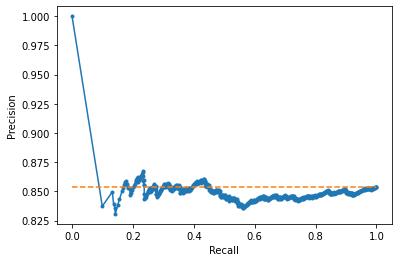

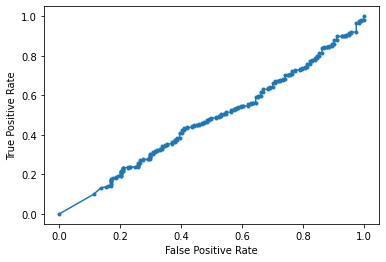

Accuracy: 75.74% Precision: 84.93% Recall: 87.03%
F1: 85.97% MCC: -0.0351
AUPRC: 85.54% AUROC: 47.53%
 accuracy [75.736160188457]
 precision [84.92597577388963]
 recall [87.0344827586207]
 F1 [85.96730245231606]
 MCC [-0.03512992675851332]
 AUPRC [85.5382797411065]
 AUROC [47.52558398220245]
2023-03-20 23:39:34.915382

Training # 2 3
2023-03-20 23:39:34.915520
2023-03-20 23:39:34.915563
Discriminator ZERO -1
Computed class weights: {0: 3.604651162790698, 1: 0.5805243445692884}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:39:36.140714


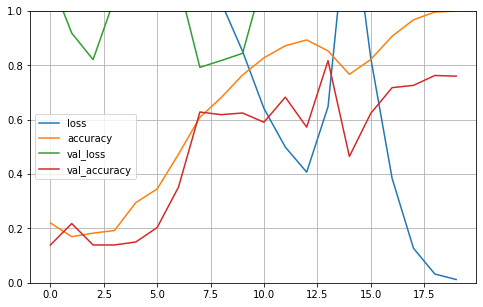


2023-03-20 23:41:59.537814

Testing # 2 3
2023-03-20 23:41:59.539442
2023-03-20 23:41:59.539842
PREDICT
2023-03-20 23:41:59.753339
Test 1:0 711:115 86.08%
Predict 1:0 713:113 86.32%
Test sizes (826, 4997) (826,)
Range of scores: 9.89491e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 15 100]
 [ 98 613]]
Normalized matrix
 [[0.01815981 0.12106538]
 [0.11864407 0.74213075]]


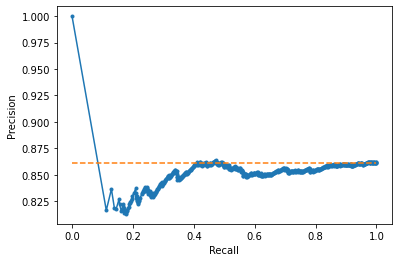

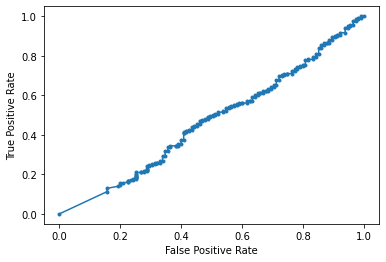

Accuracy: 76.03% Precision: 85.97% Recall: 86.22%
F1: 86.10% MCC: -0.0075
AUPRC: 85.63% AUROC: 46.91%
 accuracy [76.02905569007264]
 precision [85.97475455820476]
 recall [86.21659634317862]
 F1 [86.09550561797754]
 MCC [-0.007453970462162406]
 AUPRC [85.63186177731966]
 AUROC [46.91188161193664]
2023-03-20 23:42:01.516855

Training # 2 4
2023-03-20 23:42:01.517020
2023-03-20 23:42:01.517066
Discriminator ZERO -1
Computed class weights: {0: 3.5093555093555096, 1: 0.5830742659758203}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:42:02.718519


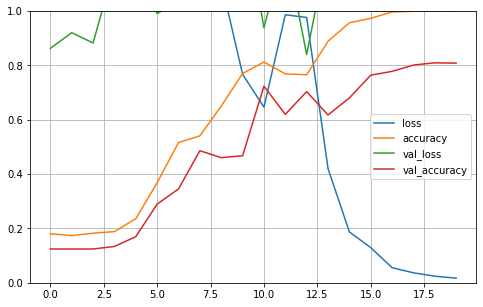


2023-03-20 23:44:26.237470

Testing # 2 4
2023-03-20 23:44:26.239173
2023-03-20 23:44:26.242476
PREDICT
2023-03-20 23:44:26.463603
Test 1:0 753:107 87.56%
Predict 1:0 780:80 90.70%
Test sizes (860, 4997) (860,)
Range of scores: 8.454e-06 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 11  96]
 [ 69 684]]
Normalized matrix
 [[0.0127907  0.11162791]
 [0.08023256 0.79534884]]


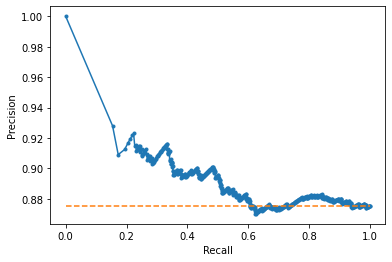

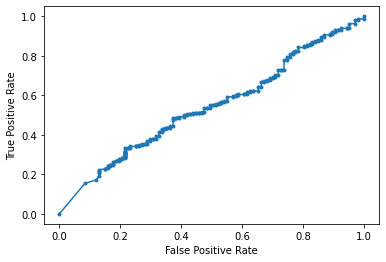

Accuracy: 80.81% Precision: 87.69% Recall: 90.84%
F1: 89.24% MCC: 0.0127
AUPRC: 90.11% AUROC: 54.24%
 accuracy [80.81395348837209]
 precision [87.6923076923077]
 recall [90.83665338645417]
 F1 [89.23679060665361]
 MCC [0.012692899390486106]
 AUPRC [90.10514116835057]
 AUROC [54.24284171724318]
2023-03-20 23:44:27.485406

Training # 2 5
2023-03-20 23:44:27.485553
2023-03-20 23:44:27.485596
Discriminator ZERO -1
Computed class weights: {0: 3.623931623931624, 1: 0.5800273597811217}
Adjusted class weights: {0: 12.0, 1: 1.0}
FIT
2023-03-20 23:44:28.699188


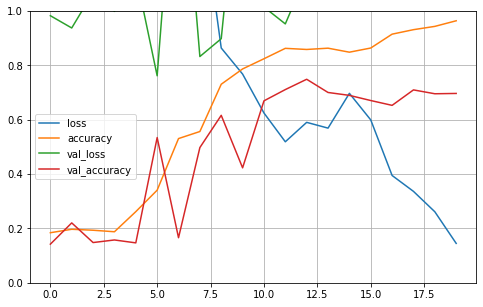


2023-03-20 23:46:52.321482

Testing # 2 5
2023-03-20 23:46:52.321586
2023-03-20 23:46:52.321623
PREDICT
2023-03-20 23:46:52.535444
Test 1:0 724:120 85.78%
Predict 1:0 662:182 78.44%
Test sizes (844, 4997) (844,)
Range of scores: 1.9957135e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 23  97]
 [159 565]]
Normalized matrix
 [[0.02725118 0.11492891]
 [0.18838863 0.66943128]]


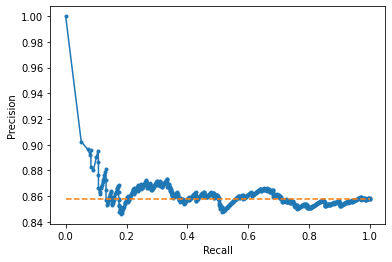

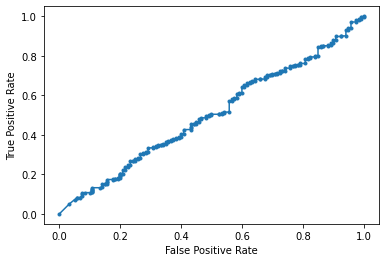

Accuracy: 69.67% Precision: 85.35% Recall: 78.04%
F1: 81.53% MCC: -0.0237
AUPRC: 86.59% AUROC: 50.21%
 accuracy [69.66824644549763]
 precision [85.3474320241692]
 recall [78.03867403314916]
 F1 [81.52958152958153]
 MCC [-0.02373143978129196]
 AUPRC [86.5883302630119]
 AUROC [50.20545580110497]
2023-03-20 23:46:53.872909


In [21]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [22]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 73.81% std 6.25
 precision mean 85.92% std 1.06
 recall mean 83.12% std 8.23
 F1 mean 84.32% std 4.74
 MCC mean -0.01% std 0.02
 AUPRC mean 87.19% std 1.30
 AUROC mean 50.27% std 2.55
 accuracy [[61.282660332541575], [74.59016393442623], [65.86248492159228], [76.91415313225059], [78.91637220259128], [78.29638273045506], [75.736160188457], [76.02905569007264], [80.81395348837209], [69.66824644549763]]
 precision [[85.25179856115108], [87.37727910238429], [84.67874794069192], [85.00651890482399], [86.76277850589777], [86.16600790513834], [84.92597577388963], [85.97475455820476], [87.6923076923077], [85.3474320241692]]
 recall [[66.01671309192201], [83.06666666666666], [73.01136363636364], [88.58695652173914], [89.45945945945945], [88.9795918367347], [87.0344827586207], [86.21659634317862], [90.83665338645417], [78.03867403314916]]
 F1 [[74.41130298273157], [85.16746411483254], [78.4134248665141], [86.7598137059215], [88.09048569527612], [87.55020080321286], [85.96730245231